In [1]:
!kaggle competitions download -c data-science-bowl-2018

data-science-bowl-2018.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import os, glob, zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import filters, segmentation, morphology, measure, feature, color, io
from scipy import ndimage as ndi
from sklearn.metrics import f1_score, jaccard_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
ZIP_FILE = "data-science-bowl-2018.zip"
EXTRACT_DIR = "data-science-bowl-2018"

if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    with zipfile.ZipFile(ZIP_FILE, 'r') as z:
        z.extractall(EXTRACT_DIR)

train_zip = os.path.join(EXTRACT_DIR, "stage1_train.zip")
if os.path.exists(train_zip):
    with zipfile.ZipFile(train_zip, 'r') as z:
        # Extract only if not already extracted
        first_entry = z.namelist()[0].split('/')[0]
        if not os.path.exists(os.path.join(EXTRACT_DIR, first_entry)):
            z.extractall(EXTRACT_DIR)

# Find training image folders (dirs with images/ and masks/ subdirs)
TRAIN_DIR = EXTRACT_DIR
image_ids = sorted([d for d in os.listdir(TRAIN_DIR)
                    if os.path.isdir(os.path.join(TRAIN_DIR, d))
                    and os.path.isdir(os.path.join(TRAIN_DIR, d, "images"))
                    and os.path.isdir(os.path.join(TRAIN_DIR, d, "masks"))])
print(f"Total training images: {len(image_ids)}")

sample = image_ids[0]
print(f"\nSample folder structure:")
for root, dirs, files in os.walk(os.path.join(TRAIN_DIR, sample)):
    level = root.replace(os.path.join(TRAIN_DIR, sample), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:3]:
        print(f"{subindent}{f}")
    if len(files) > 3:
        print(f"{subindent}... and {len(files)-3} more")

Total training images: 670

Sample folder structure:
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/
  images/
    00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png
  masks/
    07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png
    0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png
    0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png
    ... and 24 more


In [4]:
# Load image and ground truth masks
def load_image_and_masks(image_id):
    """Load image and combine individual nucleus masks into instance label map"""
    img_path = glob.glob(os.path.join(TRAIN_DIR, image_id, "images", "*.png"))[0]
    img = io.imread(img_path)
    if img.ndim == 2:  # Grayscale
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[2] == 4:  # RGBA
        img = img[:, :, :3]

    # Load individual masks → instance label map
    mask_paths = sorted(glob.glob(os.path.join(TRAIN_DIR, image_id, "masks", "*.png")))
    instance_map = np.zeros(img.shape[:2], dtype=np.int32)
    for i, mp in enumerate(mask_paths, 1):
        m = io.imread(mp)
        if m.ndim == 3:
            m = m[:, :, 0]
        instance_map[m > 128] = i

    binary_mask = (instance_map > 0).astype(np.uint8)
    return img, binary_mask, instance_map, len(mask_paths)

# Sample 50 images for evaluation
np.random.seed(42)
sample_ids = np.random.choice(image_ids, size=min(50, len(image_ids)), replace=False)

data = []
for sid in sample_ids:
    img, binary_gt, instance_gt, n_nuclei = load_image_and_masks(sid)
    data.append({"id": sid, "image": img, "binary_gt": binary_gt,
                 "instance_gt": instance_gt, "n_nuclei": n_nuclei})

print(f"Loaded {len(data)} images")
print(f"Nuclei count range: {min(d['n_nuclei'] for d in data)} - {max(d['n_nuclei'] for d in data)}")

Loaded 50 images
Nuclei count range: 5 - 199


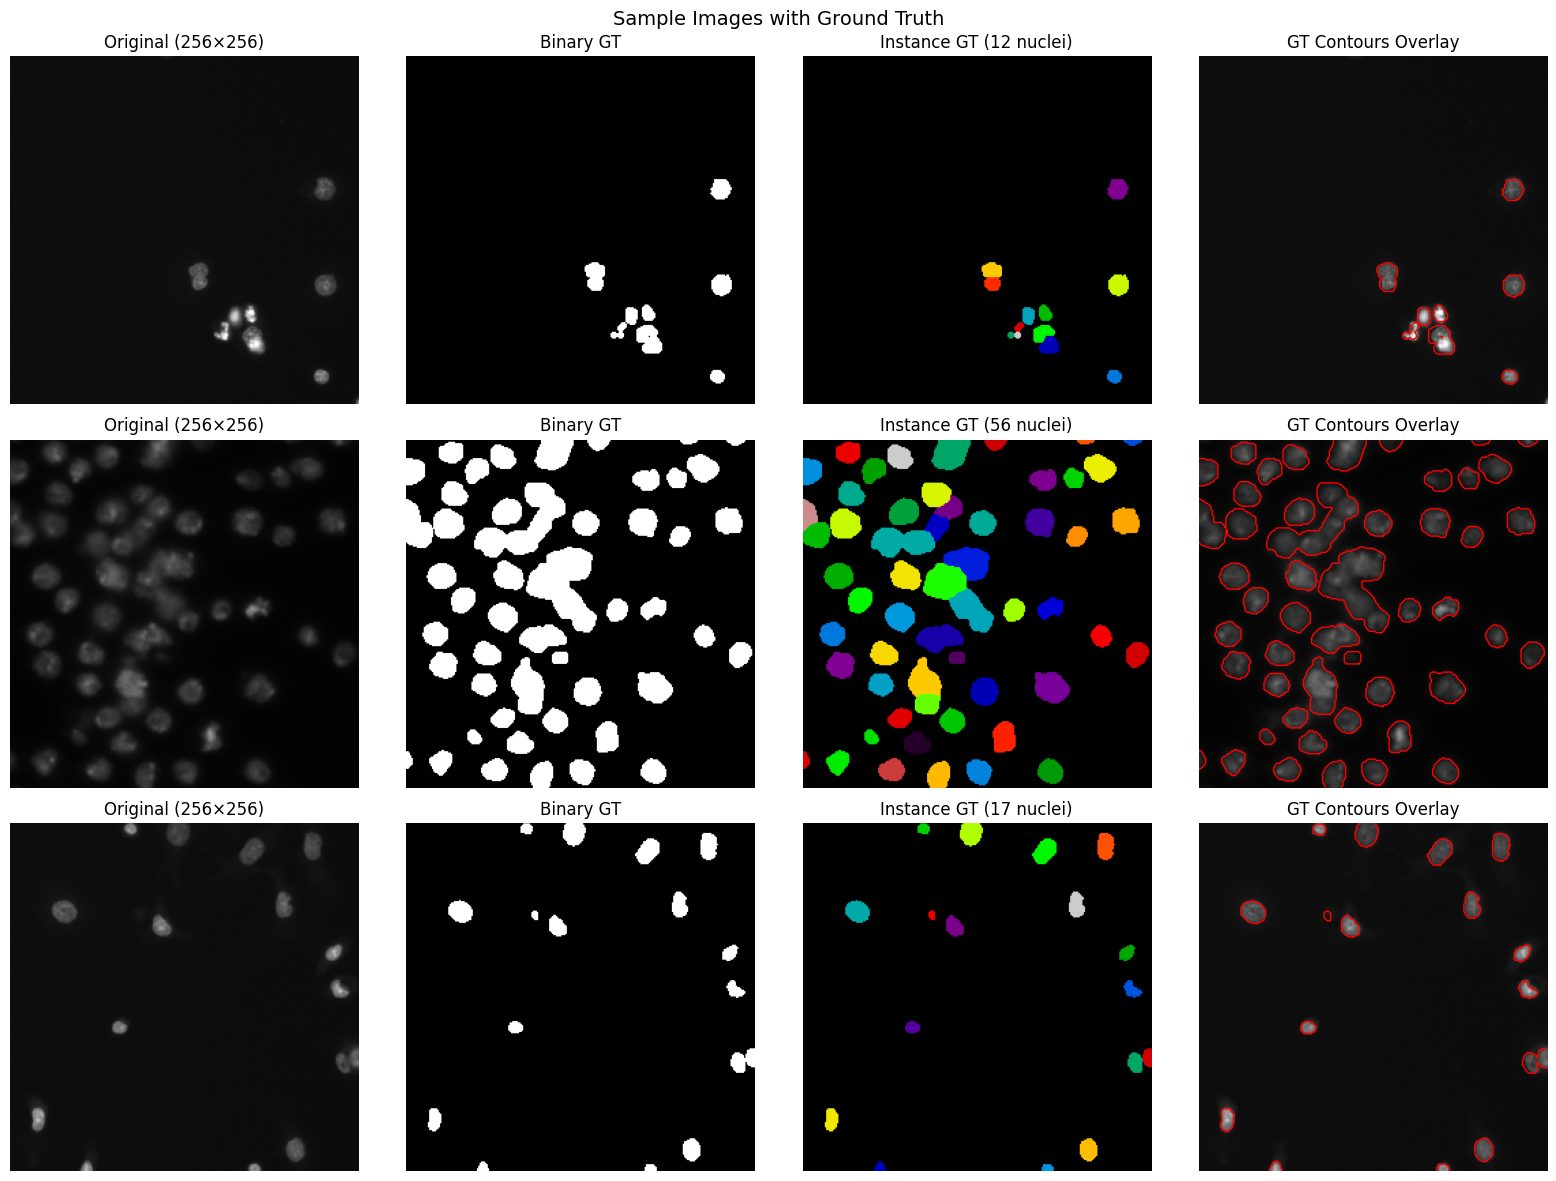

In [5]:
# Visualize sample images with ground truth
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i in range(3):
    d = data[i]
    axes[i, 0].imshow(d["image"])
    axes[i, 0].set_title(f"Original ({d['image'].shape[0]}×{d['image'].shape[1]})")

    axes[i, 1].imshow(d["binary_gt"], cmap="gray")
    axes[i, 1].set_title("Binary GT")

    axes[i, 2].imshow(d["instance_gt"], cmap="nipy_spectral")
    axes[i, 2].set_title(f"Instance GT ({d['n_nuclei']} nuclei)")

    # Overlay contours on original
    axes[i, 3].imshow(d["image"])
    contours = measure.find_contours(d["binary_gt"], 0.5)
    for c in contours:
        axes[i, 3].plot(c[:, 1], c[:, 0], 'r-', linewidth=1)
    axes[i, 3].set_title("GT Contours Overlay")

for ax in axes.flat:
    ax.axis("off")
plt.suptitle("Sample Images with Ground Truth", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
# Preprocessing: grayscale + Otsu threshold + morphological cleanup
def preprocess(img):
    """Create binary foreground mask from image"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if img.ndim == 3 else img.copy()
    thresh_val = filters.threshold_otsu(gray)

    # Nuclei can be bright or dark — pick the minority class
    binary_bright = gray > thresh_val
    binary_dark = gray < thresh_val
    binary = binary_bright if np.sum(binary_bright) < np.sum(binary_dark) else binary_dark

    # Morphological cleanup
    binary = morphology.remove_small_objects(binary, min_size=50)
    binary = morphology.remove_small_holes(binary, area_threshold=50)
    return gray, binary.astype(np.uint8)

In [7]:
# Watershed WITHOUT markers — all local minima become seeds → over-segmentation
def watershed_without_markers(binary):
    distance = ndi.distance_transform_edt(binary)
    labels = segmentation.watershed(-distance, mask=binary)
    return labels

# Watershed WITH markers — distance transform peaks as controlled seeds
def watershed_with_markers(binary, min_distance=10):
    distance = ndi.distance_transform_edt(binary)
    coords = feature.peak_local_max(distance, min_distance=min_distance, labels=binary)
    marker_mask = np.zeros(distance.shape, dtype=bool)
    marker_mask[tuple(coords.T)] = True
    markers = measure.label(marker_mask)
    labels = segmentation.watershed(-distance, markers=markers, mask=binary)
    return labels

In [8]:
# Metrics: pixel-level (Dice, IoU) and object-level (count, over-segmentation ratio)
def compute_metrics(pred_labels, gt_binary, gt_instance):
    """Compute pixel-level and object-level segmentation metrics"""
    pred_binary = (pred_labels > 0).astype(np.uint8)

    # Pixel-level metrics using sklearn
    dice = f1_score(gt_binary.flatten(), pred_binary.flatten(), zero_division=1.0)
    iou = jaccard_score(gt_binary.flatten(), pred_binary.flatten(), zero_division=1.0)

    # Object counts
    n_pred = len(np.unique(pred_labels)) - 1  # exclude background
    n_gt = len(np.unique(gt_instance)) - 1
    overseg_ratio = n_pred / max(n_gt, 1)

    return {"dice": dice, "iou": iou, "n_pred": n_pred,
            "n_gt": n_gt, "overseg_ratio": overseg_ratio}

In [9]:
# Evaluate both methods on all sampled images
results = []
for d in data:
    gray, binary = preprocess(d["image"])

    # Without markers
    labels_no = watershed_without_markers(binary)
    m_no = compute_metrics(labels_no, d["binary_gt"], d["instance_gt"])
    m_no["method"] = "Without Markers"
    m_no["id"] = d["id"]
    results.append(m_no)

    # With markers
    labels_with = watershed_with_markers(binary)
    m_with = compute_metrics(labels_with, d["binary_gt"], d["instance_gt"])
    m_with["method"] = "With Markers"
    m_with["id"] = d["id"]
    results.append(m_with)

df = pd.DataFrame(results)
print(f"Evaluation complete — {len(data)} images processed")

Evaluation complete — 50 images processed


In [10]:
# Results summary table
summary = df.groupby("method").agg({
    "dice": "mean", "iou": "mean",
    "n_pred": "mean", "n_gt": "mean", "overseg_ratio": "mean"
}).round(4)
summary.columns = ["Mean Dice", "Mean IoU", "Avg Predicted", "Avg GT", "Overseg Ratio"]
print("RESULTS SUMMARY — Watershed With vs Without Markers")
print(summary.to_string())
print("\nOverseg Ratio: predicted objects / GT objects (ideal = 1.0)")
print("  > 1.0 = over-segmentation,  < 1.0 = under-segmentation")

RESULTS SUMMARY — Watershed With vs Without Markers
                 Mean Dice  Mean IoU  Avg Predicted  Avg GT  Overseg Ratio
method                                                                    
With Markers        0.8205    0.7317          32.16    43.0         0.7853
Without Markers     0.8336    0.7521         179.12    43.0         3.4067

Overseg Ratio: predicted objects / GT objects (ideal = 1.0)
  > 1.0 = over-segmentation,  < 1.0 = under-segmentation


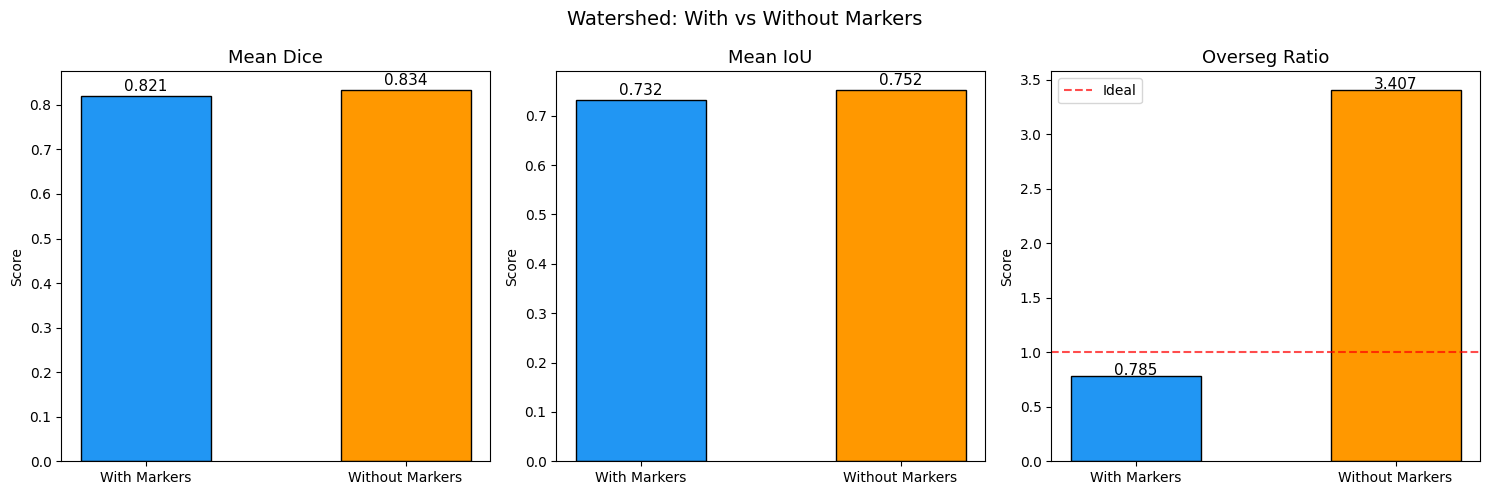

In [11]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ["#2196F3", "#FF9800"]
metrics_plot = ["Mean Dice", "Mean IoU", "Overseg Ratio"]

for i, metric in enumerate(metrics_plot):
    values = summary[metric].values
    bars = axes[i].bar(summary.index, values, color=colors, edgecolor="black", width=0.5)
    axes[i].set_title(metric, fontsize=13)
    axes[i].set_ylabel("Score")
    for bar, val in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f"{val:.3f}", ha="center", fontsize=11)
    if metric == "Overseg Ratio":
        axes[i].axhline(y=1.0, color="red", linestyle="--", alpha=0.7, label="Ideal")
        axes[i].legend()

plt.suptitle("Watershed: With vs Without Markers", fontsize=14)
plt.tight_layout()
plt.show()

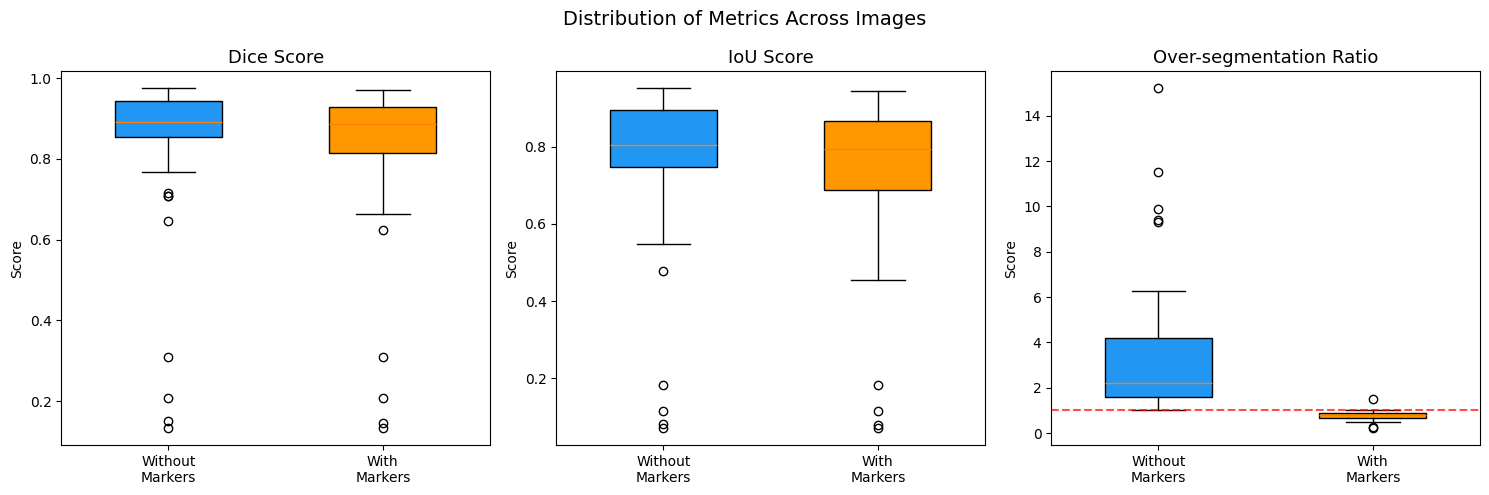

In [12]:
# Box plots for metric distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_box = ["dice", "iou", "overseg_ratio"]
titles_box = ["Dice Score", "IoU Score", "Over-segmentation Ratio"]

for i, (metric, title) in enumerate(zip(metrics_box, titles_box)):
    no_m = df[df["method"] == "Without Markers"][metric].values
    with_m = df[df["method"] == "With Markers"][metric].values
    bp = axes[i].boxplot([no_m, with_m], labels=["Without\nMarkers", "With\nMarkers"],
                         patch_artist=True, widths=0.5)
    bp["boxes"][0].set_facecolor("#2196F3")
    bp["boxes"][1].set_facecolor("#FF9800")
    axes[i].set_title(title, fontsize=13)
    axes[i].set_ylabel("Score")
    if metric == "overseg_ratio":
        axes[i].axhline(y=1.0, color="red", linestyle="--", alpha=0.7)

plt.suptitle("Distribution of Metrics Across Images", fontsize=14)
plt.tight_layout()
plt.show()

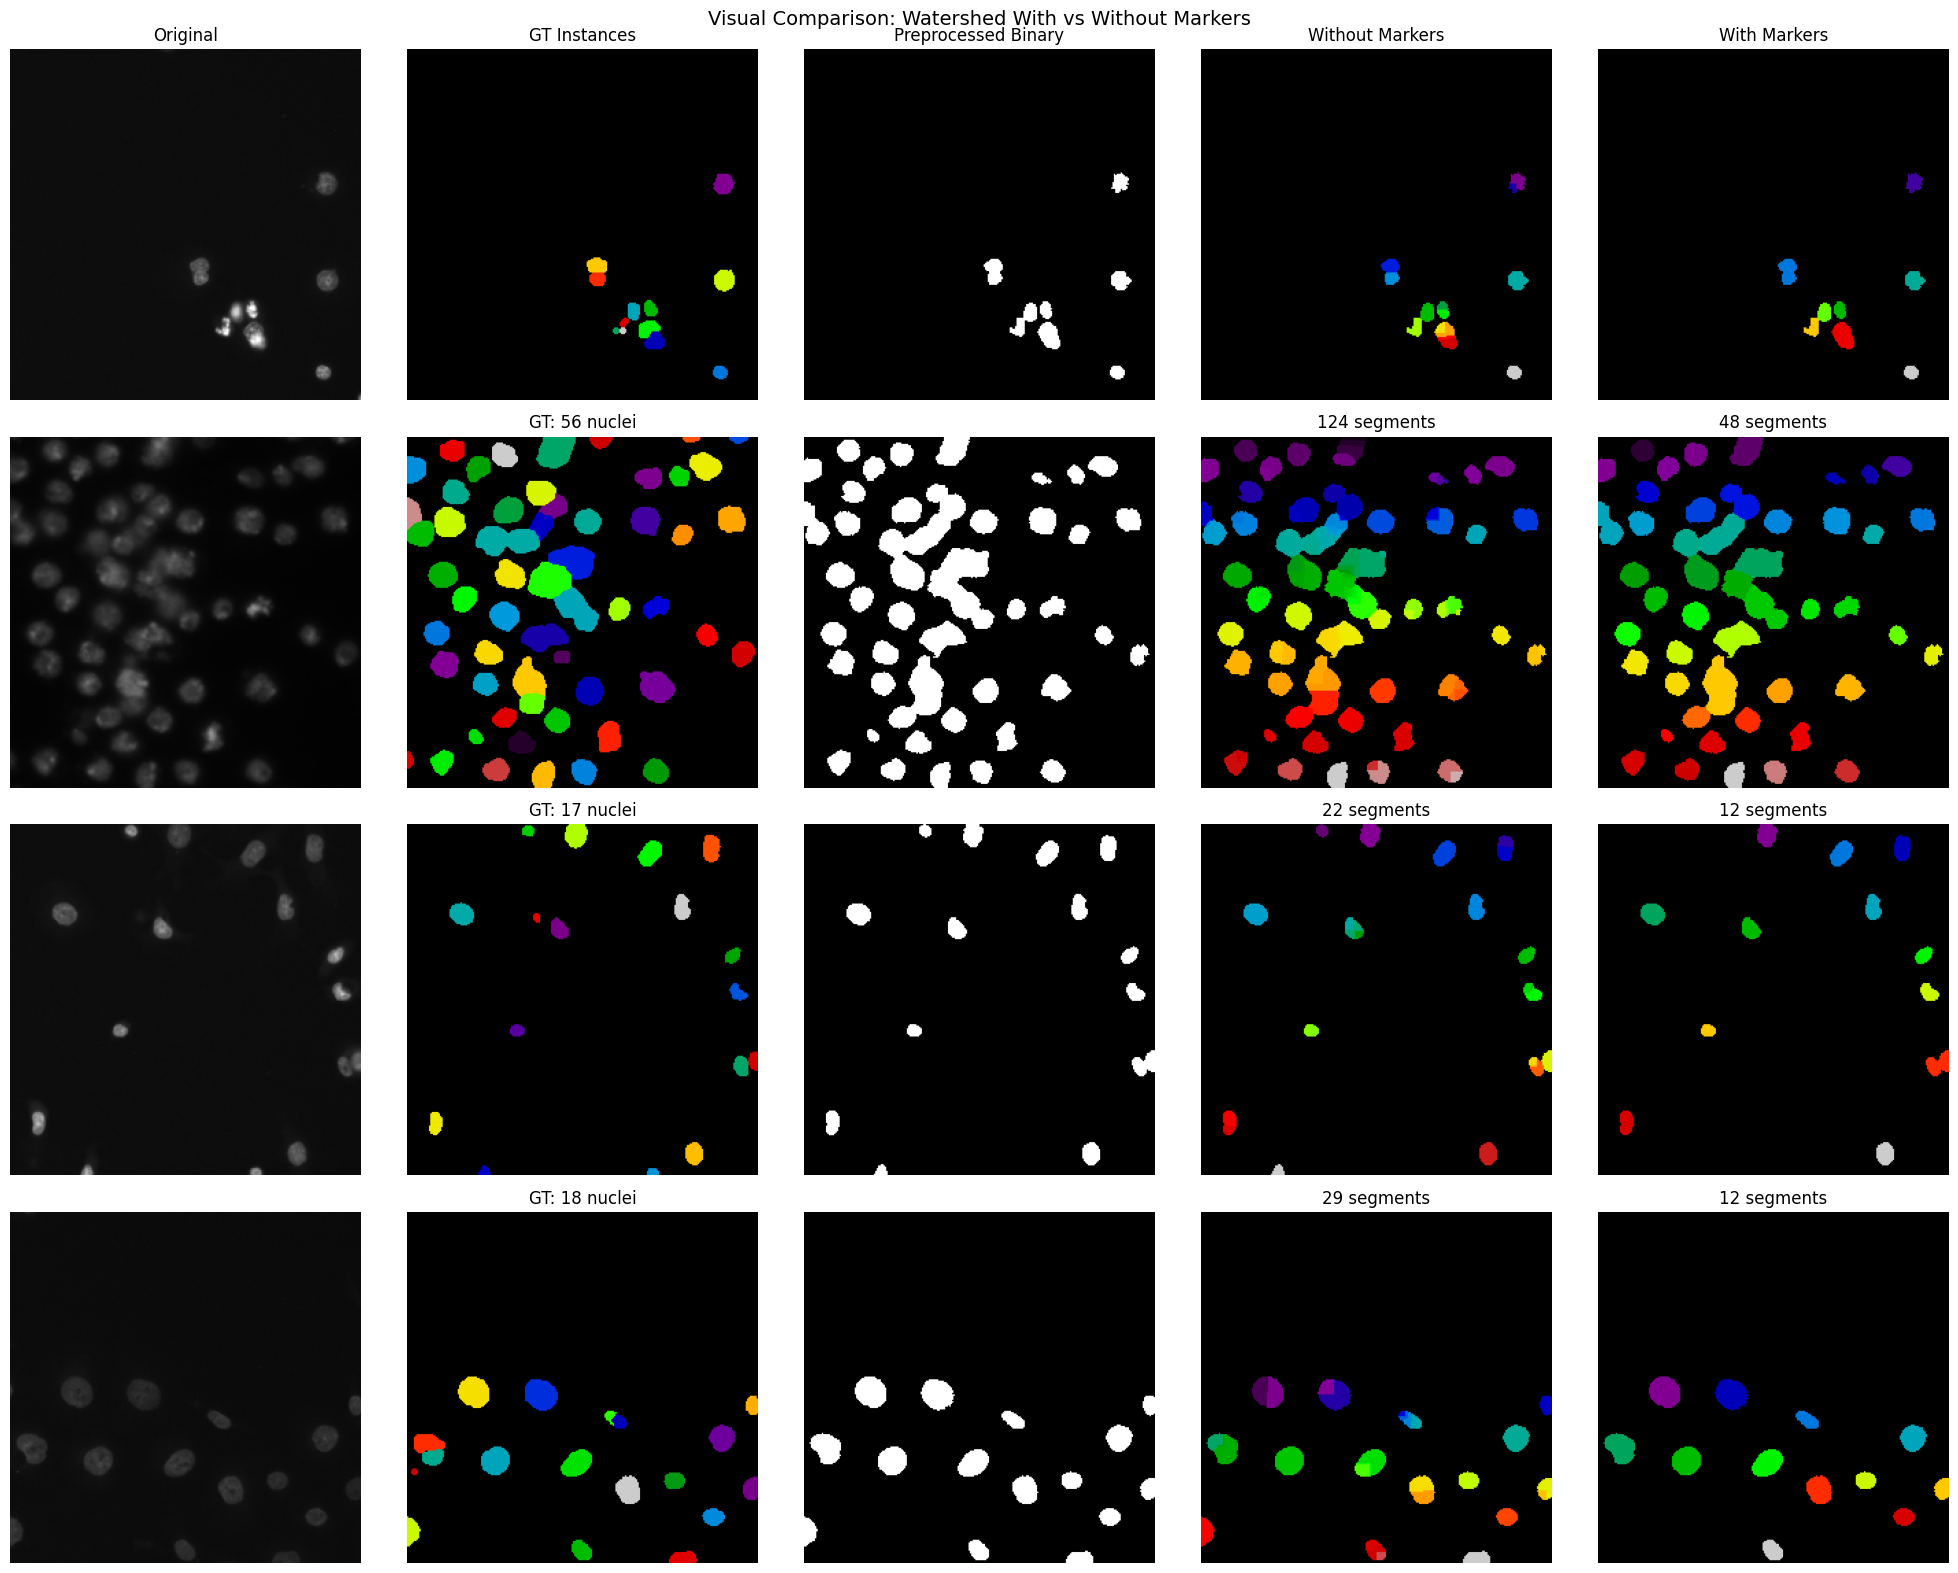

In [13]:
# Visual comparison: Original → GT → Without Markers → With Markers → Distance Transform
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
col_titles = ["Original", "GT Instances", "Preprocessed Binary", "Without Markers", "With Markers"]

for i in range(4):
    d = data[i]
    gray, binary = preprocess(d["image"])
    labels_no = watershed_without_markers(binary)
    labels_with = watershed_with_markers(binary)

    axes[i, 0].imshow(d["image"])
    axes[i, 1].imshow(d["instance_gt"], cmap="nipy_spectral")
    axes[i, 1].set_title(f"GT: {d['n_nuclei']} nuclei")
    axes[i, 2].imshow(binary, cmap="gray")
    axes[i, 3].imshow(labels_no, cmap="nipy_spectral")
    n_no = len(np.unique(labels_no)) - 1
    axes[i, 3].set_title(f"{n_no} segments")
    axes[i, 4].imshow(labels_with, cmap="nipy_spectral")
    n_with = len(np.unique(labels_with)) - 1
    axes[i, 4].set_title(f"{n_with} segments")

for j, title in enumerate(col_titles):
    axes[0, j].set_title(title, fontsize=12)
for ax in axes.flat:
    ax.axis("off")
plt.suptitle("Visual Comparison: Watershed With vs Without Markers", fontsize=14)
plt.tight_layout()
plt.show()

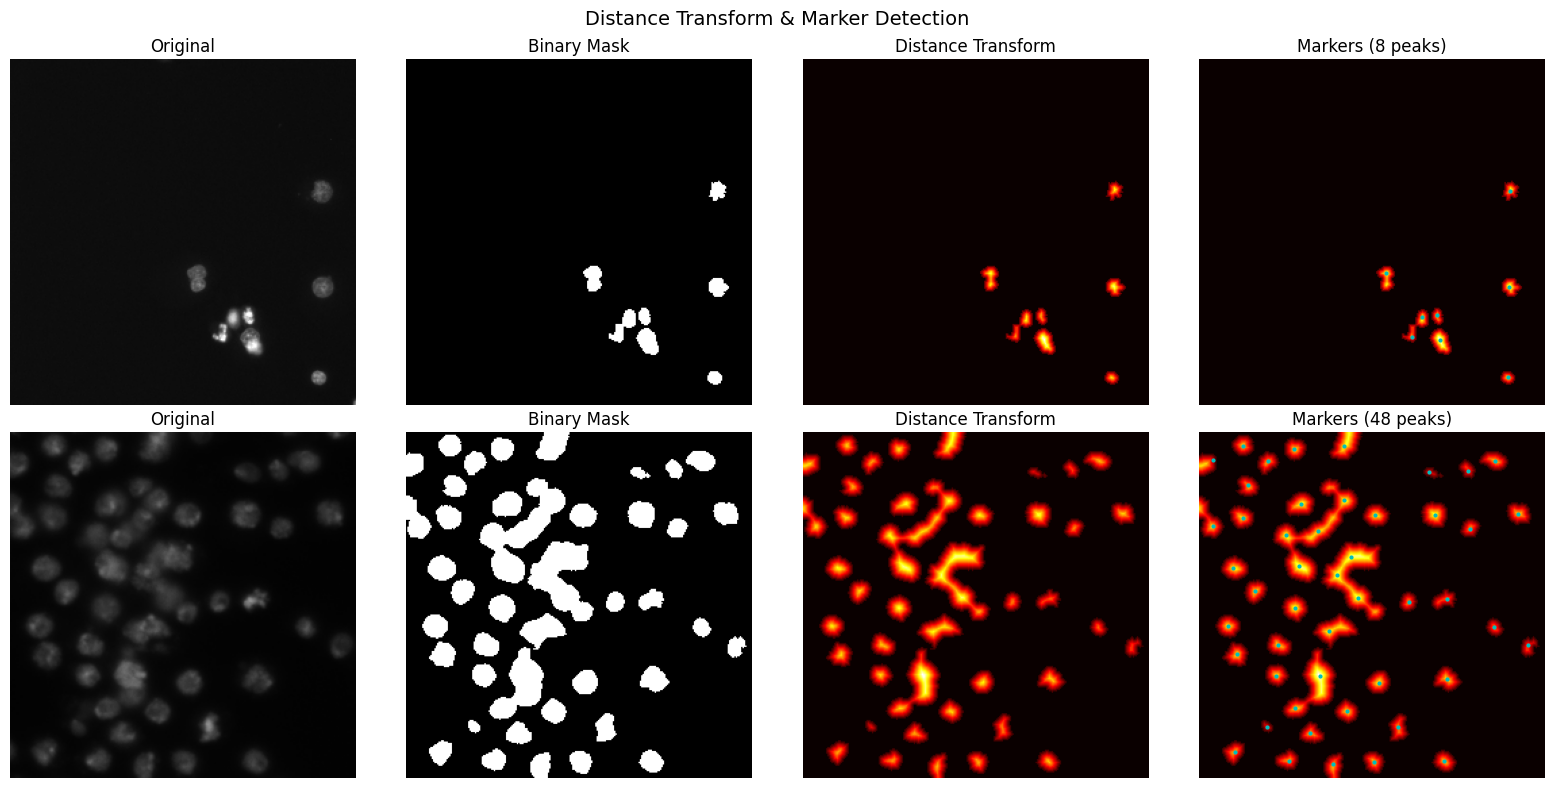

In [14]:
# Distance transform visualization — shows how markers are derived
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    d = data[i]
    gray, binary = preprocess(d["image"])
    distance = ndi.distance_transform_edt(binary)
    coords = feature.peak_local_max(distance, min_distance=10, labels=binary)

    axes[i, 0].imshow(d["image"])
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(binary, cmap="gray")
    axes[i, 1].set_title("Binary Mask")
    axes[i, 2].imshow(distance, cmap="hot")
    axes[i, 2].set_title("Distance Transform")
    axes[i, 3].imshow(distance, cmap="hot")
    axes[i, 3].plot(coords[:, 1], coords[:, 0], 'c.', markersize=4)
    axes[i, 3].set_title(f"Markers ({len(coords)} peaks)")

for ax in axes.flat:
    ax.axis("off")
plt.suptitle("Distance Transform & Marker Detection", fontsize=14)
plt.tight_layout()
plt.show()

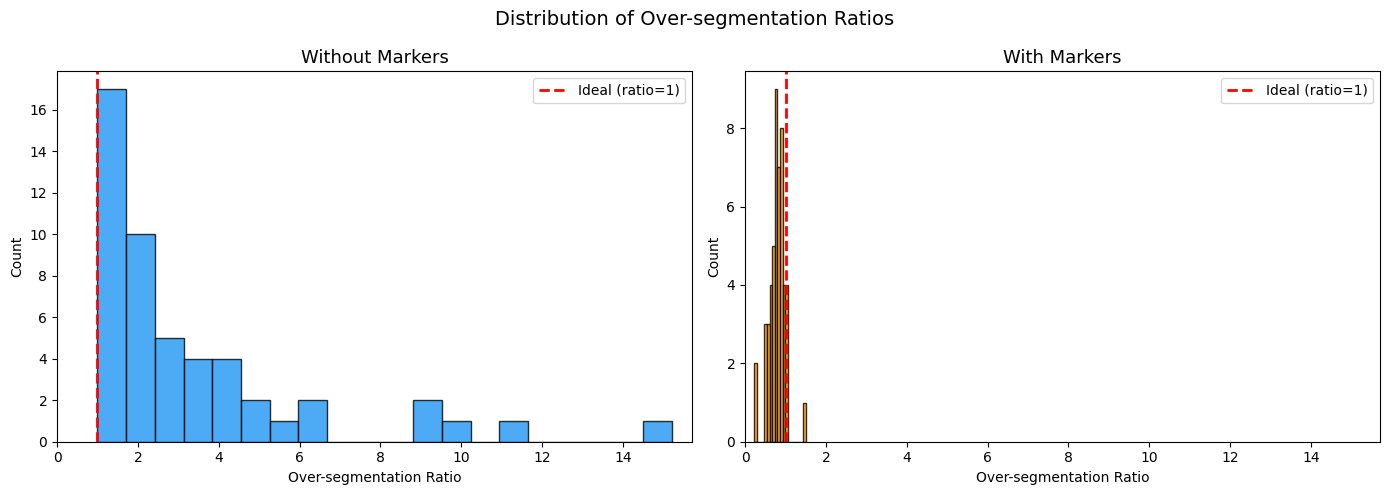

In [15]:
# Histogram of over-segmentation ratios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for method, c, ax in [("Without Markers", "#2196F3", axes[0]), ("With Markers", "#FF9800", axes[1])]:
    vals = df[df["method"] == method]["overseg_ratio"].values
    ax.hist(vals, bins=20, color=c, edgecolor="black", alpha=0.8)
    ax.axvline(x=1.0, color="red", linestyle="--", linewidth=2, label="Ideal (ratio=1)")
    ax.set_title(f"{method}", fontsize=13)
    ax.set_xlabel("Over-segmentation Ratio")
    ax.set_ylabel("Count")
    ax.legend()
    ax.set_xlim(0, max(df["overseg_ratio"].max() + 0.5, 3))

plt.suptitle("Distribution of Over-segmentation Ratios", fontsize=14)
plt.tight_layout()
plt.show()

## Conclusion

### Key Findings
- Watershed without markers uses all local minima of the distance transform as seeds, leading to over-segmentation — many nuclei get split into multiple fragments
- Marker-controlled watershed uses only prominent peaks (via peak_local_max) as seeds, producing a segmentation much closer to the ground truth object count

### Over-segmentation Control
- Without markers: every local minimum in the inverted distance transform becomes a catchment basin seed
- With markers: only peaks separated by at least min_distance pixels are used as seeds
- The min_distance parameter directly controls the trade-off between splitting touching nuclei and over-fragmenting single nuclei

### Learning
- Marker selection is critical for watershed segmentation quality — uncontrolled seeds cause severe over-segmentation
- The distance transform + peak detection pipeline is a standard approach for generating reliable markers
- Marker-controlled watershed is the preferred method for separating touching cell nuclei in biomedical images